In [1]:
import numpy as np
from numpy import ndarray
import copy
from helper_functions import *
%matplotlib inline

**Problem Statement 1**

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. 
* You have historical data from previous applicants. 
* The data includes the applicant’s scores on two exams and the admissions decision. 
* Your task is to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams. 

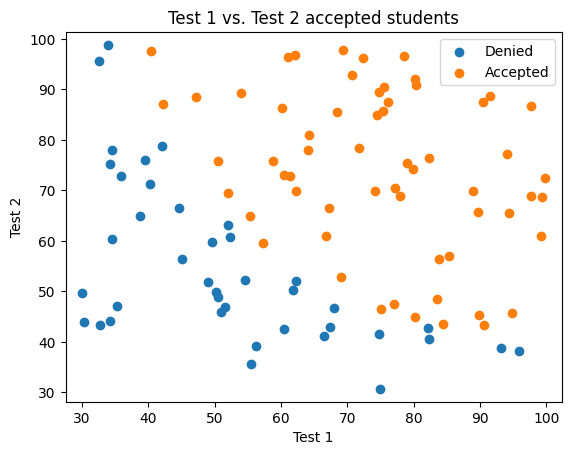

In [2]:
# Load provided data
data = np.loadtxt("data/logistic_regression1.txt", delimiter=',')
x_train1, y_train1 = data[:,0:2], data[:,2]
assert len(x_train1) == len(y_train1)
plot_data(
    x=x_train1[:, 0], y=x_train1[:, 1], title="Test 1 vs. Test 2 accepted students",
    y_title="Test 2", x_title="Test 1", colors=y_train1,
    labels={1: "Accepted", 0: "Denied"})

Define the sigmoid function to be used for the logistic regression model according to the function:
$$
g(z)=\frac{1}{1+e^{-z}}
$$

In [3]:
def sigmoid(z: ndarray) -> ndarray:
    """
    Computes the sigmoid of all values of the z array.

    Args:
        z (ndarray): Z array.

    Returns:
        ndarray: Sigmoid function applied to all values of z.
    """
    return 1 / (1 + np.exp(-z))

assert np.isclose(sigmoid(1), 0.7310585)
assert sigmoid(0) == 0.5
assert np.isclose(sigmoid(-1), 0.268941)

Define function to calculate sigmoid function:

In [4]:
def calculate_predictions(x: ndarray, w: ndarray, b: float) -> ndarray:
    """
    Calculates predictions using sigmoid function.

    Args:
        x (ndarray): Test 1 and test 2 results.
        w (ndarray): Feature parameters.
        b (float): Constant parameter.

    Returns:
        ndarray: _description_
    """
    return sigmoid(np.sum(x * w, axis=1) + b)

Define logistic loss function to prevent non-convex error function:
$$
J(\vec w, b)=\frac {-1} {m} \sum_{i=1}^m\bigg[{y^{(i)}}\log\big(f_{\vec w, v}(\vec x ^{(i)})\big)+{(1-y^{(i)})}\cdot\log\big(1- f_{\vec w, v}(\vec x ^{(i)})\big)\bigg]
$$

In [5]:
def cost_function(x: ndarray, y: ndarray, w: ndarray, b: int) -> int:
    """
    Logistic loss function.

    Args:
        x (ndarray): Test 1 and test 2 results.
        y (ndarray): Acceptance value.
        w (ndarray): Feature parameters.
        b (float): Constant parameter.

    Returns:
        int: Cost value.
    """
    m, n = x.shape

    # clip to prevent log(0)
    epsilon = 1e-10
    model_function = np.clip(calculate_predictions(x, w, b), epsilon, 1-epsilon)

    first_part = y * np.log(model_function)
    second_part = (1 - y) * np.log(1 - model_function)
    cost = np.sum(first_part + second_part)
    return -cost / m

assert np.isclose(cost_function(x_train1, y_train1, np.array([0, 0]), 0), 0.693147)
assert np.isclose(cost_function(x_train1, y_train1, [0.5698, 0.1113], 0.00299), 9.1978)

Calculate gradient using the following formulas for each step:
$$
w_j=w_j-\frac 1 {m} \sum_{i=0}^{m-1} \big( f_{ w,b}(x^{(i)}) -y^{(i)}\big)x^{(i)}_j
$$
$$
b=b-\frac 1 {m} \sum_{i=0}^{m-1} \big( f_{ w,b}(x^{(i)}) -y^{(i)}\big)
$$

In [6]:
def calculate_gradient(x: ndarray, y: ndarray,
        w: float, b: float, *args) -> tuple[float, float]: 
    """
    Calculates gradient for all w and b parameters.

    Args:
        x (ndarray): Test 1 and test 2 results.
        y (ndarray): Acceptance value.
        wi (ndarray): Feature parameters.
        bi (float): Constant parameter.

    Returns:
        tuple[float, float]: Gradient cost of parameters w and b.
    """
    m, n = x.shape
    predictions_offset = calculate_predictions(x, w, b) - y
    w_gradient = (1 / m) * np.sum(x * predictions_offset.reshape(-1, 1), axis=0)
    b_gradient = (1 / m) * np.sum(predictions_offset)
    return w_gradient, b_gradient

w_grad, b_grad = calculate_gradient(x_train1, y_train1, np.zeros(2), 0)
assert np.allclose(w_grad, [-12.009216, -11.262842])
assert b_grad == -0.1

Find the optimal parameters using batch gradient descent using the logistic loss function:
$$ 
J(\vec w, b)=\frac {-1} {m} \sum_{i=1}^m\bigg[{y^{(i)}}\log\big(f_{\vec w, v}(\vec x ^{(i)})\big)+{(1-y^{(i)})}\cdot\log\big(1- f_{\vec w, v}(\vec x ^{(i)})\big)\bigg]
$$

In [7]:
def gradient_descent(x: ndarray, y: ndarray, wi: ndarray, bi: float,
    alpha: float, cost_func, gradient_func, iterations: int, lambda_val: float
) -> tuple[float, float, list[float], list[float], list[float]]:
    """
    Performs batch gradient descent to learn theta.

    Args:
        x (ndarray): Test 1 and test 2 results.
        y (ndarray): Acceptance value.
        wi (ndarray): Feature parameters (initial values).
        bi (float): Constant parameter (initial value).
        alpha (float): Learning rate.
        cost_func: Cost function.
        gradient_func: Gradient function.
        iterations (int): Number of iterations to perform gradient descent.
        lambda_val (float): Regularization parameter.

    Returns:
        tuple[float, float, list[float], list[float]]:
            - Optimal w parameters.
            - Optimal b parameter.
            - History of cost.
            - History of w parameters.
            - History of b parameter.
    """
    m, n = x.shape
    J_history = []
    w_history = []
    b_history = []
    w = copy.deepcopy(wi)
    b = copy.deepcopy(bi)

    for i in range(iterations):
        w_gradients, b_gradient = gradient_func(x, y, w, b, lambda_val)
        w = w - w_gradients * alpha
        b = b - b_gradient * alpha
        cost = cost_func(x, y, w, b)
        J_history.append(cost)
        w_history.append(w)
        b_history.append(b)
    return w, b, J_history, w_history, b_history

w values: [0.07125355 0.06482888]
b value: -8.188622906609844
final cost: 0.3018680668140089


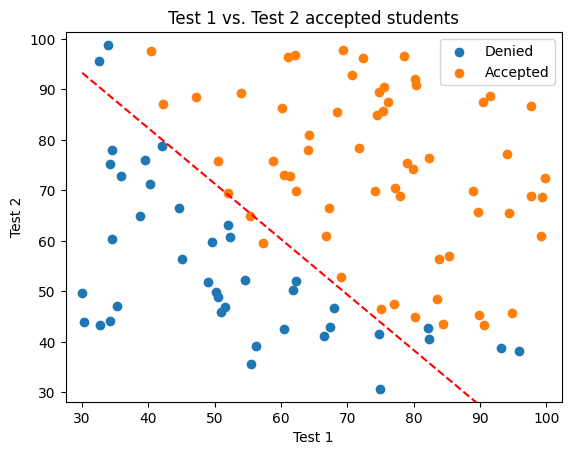

In [8]:
# Run the algorithm
initial_w = [-0.00082978, 0.00220324]
initial_b = -8
iterations = 10000
alpha = 0.001

w, b, J_history, w_history, b_history = gradient_descent(
    x_train1, y_train1, initial_w, initial_b, alpha,
    cost_function, calculate_gradient, iterations, 0)

# Calculate predictions and plot
predicted = calculate_predictions(x_train1, w, b)
print(f"w values: {w}\nb value: {b}\nfinal cost: {J_history[-1]}")
plot_data(
    x=x_train1[:, 0], y=x_train1[:, 1], title="Test 1 vs. Test 2 accepted students",
    y_title="Test 2", x_title="Test 1", colors=y_train1,
    labels={1: "Accepted", 0: "Denied"})
plot_boundary_line(x=x_train1, w=w, b=b)

Create a predict function to produce a True or False value with a 0.5 threshold:

In [9]:
def predict(x: ndarray, w: ndarray, b: float) -> bool:
    """
    Predicts labels from x dataset using regression parameters.

    Args:
        x (ndarray): x dataset.
        w (ndarray): w parameters.
        b (float): b parameter.

    Returns:
        bool: Label.
    """
    predictions = sigmoid(np.sum(x * w, axis=1) + b)
    predictions[predictions > 0.5] = 1
    predictions[predictions <= 0.5] = 0
    return predictions

p = predict(x_train1, w,b)
print(f'Training Accuracy: {(np.mean(p == y_train1) * 100)}%')

Training Accuracy: 92.0%


**Problem Statement 2**

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. 
* From these two tests, you would like to determine whether the microchips should be accepted or rejected. 
* To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.


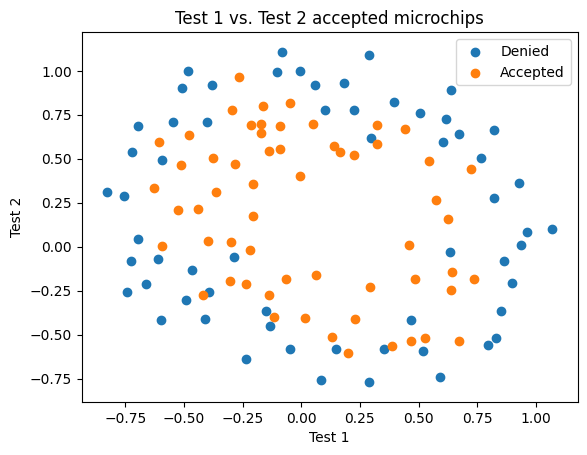

In [10]:
# Load provided data
data = np.loadtxt("data/logistic_regression2.txt", delimiter=',')
x_train2, y_train2 = data[:,0:2], data[:,2]
assert len(x_train2) == len(y_train2)
plot_data(
    x=x_train2[:, 0], y=x_train2[:, 1],
    title="Test 1 vs. Test 2 accepted microchips",
    y_title="Test 2", x_title="Test 1", colors=y_train2,
    labels={1: "Accepted", 0: "Denied"}, margin_scale=0.1)

Create a function to apply feature mapping up to a sixth degree term:

In [11]:
def feature_map(x1: ndarray, x2: ndarray) -> ndarray:
    """
    Applies feature mapping up to sixth degree.

    Args:
        x1 (ndarray): x1 dataset.
        x2 (ndarray): x2 dataset.

    Returns:
        ndarray: New dataset with feature mapping.
    """
    x1 = np.atleast_1d(x1)
    x2 = np.atleast_1d(x2)
    out = []
    for i in range(1, 7):
        for j in range(i + 1):
            out.append((x1**(i-j) * (x2**j)))
    return np.stack(out, axis=1)

Define regularized logistic loss function to prevent non-convex error function:
$$ 
J(\vec w, b)=\frac {-1} {m} \sum_{i=1}^m\bigg[{y^{(i)}}\log\big(f_{\vec w, v}(\vec x ^{(i)})\big)+{(1-y^{(i)})}\cdot\log\big(1- f_{\vec w, v}(\vec x ^{(i)})\big)\bigg] + \frac{\lambda}{2m}\sum^n_{j=1}w^2_j
$$

In [12]:
def regularized_cost_function(
    x: ndarray, y: ndarray, w: ndarray, b: int, lambda_val: float = 1.0
) -> int:
    """
    Logistic loss function.

    Args:
        x (ndarray): Test 1 and test 2 results.
        y (ndarray): Acceptance value.
        w (ndarray): Feature parameters.
        b (float): Constant parameter.
        lambda_val (float): Regularization parameter.

    Returns:
        int: Regularized cost value.
    """
    m, n = x.shape
    unregularized_cost = cost_function(x, y, w, b)
    regularization_term = lambda_val / (2 * m) * np.sum(w ** 2)
    return unregularized_cost + regularization_term

X_mapped = feature_map(x_train2[:, 0], x_train2[:, 1])
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5
cost = regularized_cost_function(X_mapped, y_train2, initial_w, 0.5, 0.5)
assert np.isclose(cost, 0.661825)

Calculate regularized gradient using the following formulas for each step:
$$
w_j=w_j-\frac 1 {m} \sum_{i=0}^{m-1} \big( f_{ w,b}(x^{(i)}) -y^{(i)}\big)x^{(i)}_j  + \frac {\lambda} { m} w_j
$$
$$
b=b-\frac 1 {m} \sum_{i=0}^{m-1} \big( f_{ w,b}(x^{(i)}) -y^{(i)}\big)
$$

In [13]:
def calculate_regularized_gradient(x: ndarray, y: ndarray,
        w: float, b: float, lambda_val: float) -> tuple[float, float]: 
    """
    Calculates regularized gradient for all w and b parameters.

    Args:
        x (ndarray): Test 1 and test 2 results.
        y (ndarray): Acceptance value.
        wi (ndarray): Feature parameters.
        bi (float): Constant parameter.
        lambda_val (float): Regularization parameter.

    Returns:
        tuple[float, float]: Gradient cost of parameters w and b.
    """
    m, n = x.shape
    unregularized_w, b_gradient = calculate_gradient(x, y, w, b)
    regulatization_term = w * lambda_val / m
    return unregularized_w + regulatization_term, b_gradient

X_mapped = feature_map(x_train2[:, 0], x_train2[:, 1])
np.random.seed(1) 
initial_w  = np.random.rand(X_mapped.shape[1]) - 0.5 
w_grad, b_grad = calculate_regularized_gradient(
    X_mapped, y_train2, initial_w, 0.5, 0.5)
assert np.allclose(w_grad, [
    -1.03860285e-02,  1.14098529e-02,  5.36273463e-02,  3.14027827e-03,
    5.01867884e-02,  1.95790777e-03,  7.92993393e-03,  1.84553785e-03,
    2.70381993e-02,  3.73889404e-02, -7.01847299e-04,  1.50852004e-02,
    -1.97956109e-03,  4.50462354e-02,  8.08714799e-03,  5.55987190e-03,
    8.57279753e-04,  6.84603073e-03,  3.22962618e-05,  3.01820438e-02,
    2.81992064e-02,  1.79123580e-03,  5.63190166e-03,  1.48413396e-04,
    9.37736972e-03,  5.44289748e-04,  3.71889580e-02])
assert np.isclose(b_grad, 0.0713828)

Create a predict function to produce a True or False value with a 0.5 threshold:

w values: [ 0.91942591  1.498808   -2.60245258 -1.02553909 -1.71585623 -0.09592211
 -0.71160079 -0.45730613 -0.26340681 -1.50698147 -0.14270698 -0.44153586
 -0.52508092 -0.85837858 -0.62573584 -0.07261085 -0.11805904 -0.22722724
 -0.62605666 -0.82141607 -0.81504549  0.47841069 -0.48917343  0.20341741
  0.03868363  0.28008285 -1.44112378]
b value: 1.4386736500564228
final cost: 0.5413973911173415


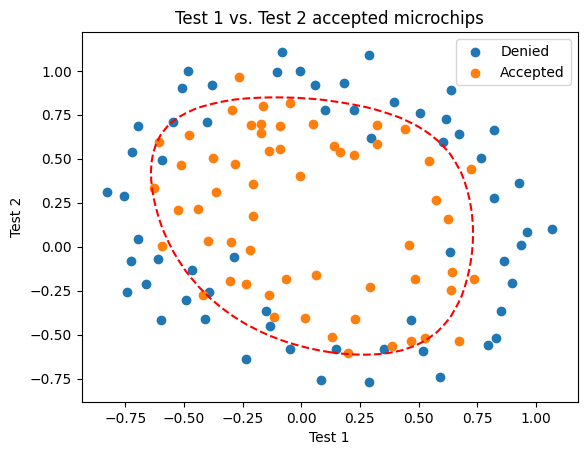

In [14]:
# Run the algorithm
X_mapped = feature_map(x_train2[:, 0], x_train2[:, 1])
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1])-0.5
initial_b = 1.0
lambda_ = 0.01
iterations = 10000
alpha = 0.01

w, b, J_history, w_history, b_history = gradient_descent(
    X_mapped, y_train2, initial_w, initial_b, alpha,
    regularized_cost_function, calculate_regularized_gradient, iterations, 0)

# Calculate predictions and plot
print(f"w values: {w}\nb value: {b}\nfinal cost: {J_history[-1]}")
plot_data(
    x=x_train2[:, 0], y=x_train2[:, 1],
    title="Test 1 vs. Test 2 accepted microchips",
    y_title="Test 2", x_title="Test 1", colors=y_train2,
    labels={1: "Accepted", 0: "Denied"}, margin_scale=0.1)
plot_boundary_line(X_mapped, w, b)